In [15]:
import pandas as pd
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Ensure working directory is the notebook's location
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("lab.ipynb"))
os.chdir(NOTEBOOK_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/fauzanghaza/Documents/code/kubernetes-autoscaling/result/inferensial_test


In [ ]:
METRICS = [
    ("../cap_30/pod_10", "response_time", "Response Time (ms)", 10),
    ("../cap_30/pod_10", "replica", "Replica Count", 10),
    ("../cap_30/pod_10", "cpu", "CPU Usage", 10),
    ("../cap_30/pod_10", "memory", "Memory Usage", 10),
    ("../cap_30/pod_20", "response_time", "Response Time (ms)", 20),
    ("../cap_30/pod_20", "replica", "Replica Count", 20),
    ("../cap_30/pod_20", "cpu", "CPU Usage", 20),
    ("../cap_30/pod_20", "memory", "Memory Usage", 20),
]

DEPLOYMENTS = {"HPA": "hpa-flask-app", "RL": "test-flask-app"}

In [17]:
def get_run_means(base_path):
    hpa, rl = [], []
    for i in range(1, 21):  # Check files 1.csv to 20.csv
        path = f"{base_path}/{i}.csv"
        if not os.path.exists(path):
            continue  # Skip missing files instead of stopping

        try:
            # InfluxDB annotated CSV: 3 annotation rows, then header at row index 3
            df = pd.read_csv(path, header=3)

            # Fallback: try reading without annotation rows (plain CSV)
            if '_value' not in df.columns:
                df = pd.read_csv(path)

            print(f"Loaded {path}: {len(df)} rows")

            if 'deployment' in df.columns and '_value' in df.columns:
                means = df.groupby('deployment')['_value'].mean()
                if DEPLOYMENTS["HPA"] in means: hpa.append(means[DEPLOYMENTS["HPA"]])
                if DEPLOYMENTS["RL"] in means: rl.append(means[DEPLOYMENTS["RL"]])
        except Exception as e:
            print(f"Skipping {path}: {e}")

    return hpa, rl

def analyze_stats(hpa, rl):
    n = min(len(hpa), len(rl))
    if n < 3: return None  # Need at least 3 samples for Shapiro-Wilk/tests

    x, y = hpa[:n], rl[:n]

    # Normality check (Shapiro-Wilk)
    # H0: Distribution is Normal. If p > 0.05, we fail to reject H0 (assume normal).
    shapiro_hpa = stats.shapiro(x)
    shapiro_rl = stats.shapiro(y)

    is_normal = (shapiro_hpa.pvalue > 0.05) and (shapiro_rl.pvalue > 0.05)

    # Statistical Test
    diff = np.array(x) - np.array(y)

    # Guard: if all differences are zero, no test is meaningful
    if np.allclose(diff, 0):
        return {
            "N": n,
            "HPA Mean": np.mean(x),
            "RL Mean": np.mean(y),
            "Diff (%)": 0.0,
            "Normality P(HPA)": shapiro_hpa.pvalue,
            "Normality P(RL)": shapiro_rl.pvalue,
            "P-Value": 1.0,
            "Significant": False,
            "Test": "N/A (identical values)",
            "Effect Size": 0.0
        }

    if is_normal:
        stat, p_val = stats.ttest_rel(x, y)
        test_name = "Paired t-test"
    else:
        try:
            stat, p_val = stats.wilcoxon(x, y)
            test_name = "Wilcoxon"
        except ValueError as e:
            # Wilcoxon can fail on edge cases (e.g., too few non-zero differences)
            print(f"  Wilcoxon failed ({e}), falling back to Paired t-test")
            stat, p_val = stats.ttest_rel(x, y)
            test_name = "Paired t-test (fallback)"

    # Effect Size (Cohen's d for paired samples)
    std_diff = np.std(diff, ddof=1)
    cohens_d = np.mean(diff) / std_diff if std_diff != 0 else 0

    return {
        "N": n,
        "HPA Mean": np.mean(x),
        "RL Mean": np.mean(y),
        "Diff (%)": (np.mean(y) - np.mean(x)) / np.mean(x) * 100 if np.mean(x) != 0 else np.nan,
        "Normality P(HPA)": shapiro_hpa.pvalue,
        "Normality P(RL)": shapiro_rl.pvalue,
        "P-Value": p_val,
        "Significant": p_val < 0.05,
        "Test": test_name,
        "Effect Size": cohens_d
    }

In [18]:
def save_normality_plots(hpa, rl, folder, metric_dir, label, pod):
    # Create the directory structure: e.g., result/inferensial_test/pod_10/response_time/
    output_dir = f"{folder}/{metric_dir}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving plots to: {output_dir}/")

    # --- 1. Save INDIVIDUAL plots ---
    # HPA Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(hpa, bins='auto', alpha=0.7, color='blue', edgecolor='black', rwidth=0.85)
    plt.title(f"HPA Histogram - {label}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/inferensial_histogram_{metric_dir}_hpa_{pod}_pod.png")
    plt.close()

    # HPA Q-Q Plot
    plt.figure(figsize=(6, 4))
    stats.probplot(hpa, dist="norm", plot=plt)
    plt.title(f"HPA Q-Q Plot - {label}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/inferensial_qq_plot_{metric_dir}_hpa_{pod}_pod.png")
    plt.close()

    # RL Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(rl, bins='auto', alpha=0.7, color='green', edgecolor='black', rwidth=0.85)
    plt.title(f"RL Histogram - {label}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/inferensial_histogram_{metric_dir}_rl_{pod}_pod.png")
    plt.close()

    # RL Q-Q Plot
    plt.figure(figsize=(6, 4))
    stats.probplot(rl, dist="norm", plot=plt)
    plt.title(f"RL Q-Q Plot - {label}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/inferensial_qq_plot_{metric_dir}_rl_{pod}_pod.png")
    plt.close()

    # --- 2. Show SUMMARY plot (Combined) ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Normality Analysis: {label} ({folder})", fontsize=16)

    # Plot on subplots
    axes[0, 0].hist(hpa, bins='auto', alpha=0.7, color='blue', edgecolor='black', rwidth=0.85)
    axes[0, 0].set_title(f"HPA Histogram")
    axes[0, 0].set_ylabel("Frequency")

    stats.probplot(hpa, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title(f"HPA Q-Q Plot")

    axes[1, 0].hist(rl, bins='auto', alpha=0.7, color='green', edgecolor='black', rwidth=0.85)
    axes[1, 0].set_title(f"RL Histogram")
    axes[1, 0].set_ylabel("Frequency")

    stats.probplot(rl, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f"RL Q-Q Plot")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for main title
    plt.show()



## Prosedur Pemilihan Metode Uji Statistik

Notebook ini menggunakan pendekatan sistematis untuk memilih metode uji yang sesuai:

### 1. **Uji Normalitas (Shapiro-Wilk Test)**
Langkah pertama adalah menguji apakah data mengikuti distribusi normal:
- **Hipotesis Nol (H₀):** Data mengikuti distribusi normal
- **Kriteria:** Jika *p*-value > 0,05 → Data dianggap normal
- **Dilakukan untuk:** Data HPA dan data RL secara terpisah

**Formula Shapiro-Wilk:**
$$W = \frac{\left(\sum_{i=1}^{n} a_i x_{(i)}\right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$

Dimana:
- $x_{(i)}$ = nilai sampel yang diurutkan
- $a_i$ = konstanta yang dihasilkan dari mean, varians, dan kovarians dari statistik order
- $n$ = jumlah sampel
- Nilai $W$ mendekati 1 menunjukkan data mendekati distribusi normal

### 2. **Pemilihan Metode Uji**
Berdasarkan hasil uji normalitas:

#### **A. Paired t-test (Uji Parametrik)**
**Digunakan jika:** Kedua distribusi (HPA dan RL) bersifat normal

**Formula:**
$$t = \frac{\bar{d}}{s_d / \sqrt{n}}$$

Dimana:
- $\bar{d}$ = rata-rata dari selisih berpasangan ($d_i = x_i - y_i$)
- $s_d$ = standar deviasi dari selisih: $s_d = \sqrt{\frac{\sum_{i=1}^{n}(d_i - \bar{d})^2}{n-1}}$
- $n$ = jumlah pasangan sampel
- Derajat kebebasan: $df = n - 1$

**Asumsi:** 
- Data berpasangan
- Distribusi normal
- Skala pengukuran interval/rasio

**Effect Size - Cohen's *d* untuk paired samples:**
$$d = \frac{\bar{d}}{s_d}$$

Interpretasi:
- $|d| < 0.2$: efek sangat kecil
- $0.2 \leq |d| < 0.5$: efek kecil
- $0.5 \leq |d| < 0.8$: efek sedang
- $|d| \geq 0.8$: efek besar

#### **B. Wilcoxon Signed-Rank Test (Uji Non-Parametrik)**
**Digunakan jika:** Salah satu atau kedua distribusi tidak normal

**Formula:**
$$W = \sum_{i=1}^{n} [\text{sgn}(x_i - y_i) \cdot R_i]$$

Langkah perhitungan:
1. Hitung selisih: $d_i = x_i - y_i$
2. Abaikan $d_i = 0$
3. Urutkan $|d_i|$ dan beri rank $R_i$
4. Kalikan rank dengan tanda dari $d_i$
5. Jumlahkan signed ranks untuk mendapatkan statistik $W$

**Asumsi:**
- Data berpasangan
- Tidak memerlukan distribusi normal
- Skala pengukuran ordinal, interval, atau rasio
- Distribusi simetris dari selisih

**Effect Size - *r* untuk Wilcoxon:**
$$r = \frac{Z}{\sqrt{n}}$$

Dimana:
- $Z$ = statistik normal dari Wilcoxon test
- $n$ = jumlah pasangan sampel

Atau menggunakan formula alternatif yang digunakan dalam kode ini:
$$r = \frac{|\bar{d}|}{s_d}$$

**Keuntungan:** Lebih robust terhadap outlier dan data tidak normal

### 3. **Formula Selisih Persentase**
$$\text{Diff (\%)} = \frac{\bar{x}_{\text{RL}} - \bar{x}_{\text{HPA}}}{\bar{x}_{\text{HPA}}} \times 100\%$$

Dimana:
- $\bar{x}_{\text{HPA}}$ = rata-rata nilai HPA
- $\bar{x}_{\text{RL}}$ = rata-rata nilai RL
- Nilai negatif: RL lebih rendah dari HPA
- Nilai positif: RL lebih tinggi dari HPA

### 4. **Interpretasi Effect Size**

| Cohen's *d* / *r* | Interpretasi |
|-------------------|--------------|
| < 0.2 | Sangat kecil |
| 0.2 - 0.5 | Kecil |
| 0.5 - 0.8 | Sedang |
| > 0.8 | Besar |

### 5. **Contoh Penerapan dalam Kode**
```python
# Dalam fungsi analyze_stats():

# Step 1: Uji normalitas
shapiro_hpa = stats.shapiro(x)  # Shapiro-Wilk test untuk HPA
shapiro_rl = stats.shapiro(y)   # Shapiro-Wilk test untuk RL

is_normal = (shapiro_hpa.pvalue > 0.05) and (shapiro_rl.pvalue > 0.05)

# Step 2: Hitung selisih
diff = np.array(x) - np.array(y)  # d_i = HPA_i - RL_i

# Step 3: Pilih uji statistik
if is_normal:
    # Kedua distribusi normal → Paired t-test
    stat, p_val = stats.ttest_rel(x, y)
    test_name = "Paired t-test"
else:
    # Salah satu tidak normal → Wilcoxon
    stat, p_val = stats.wilcoxon(x, y)
    test_name = "Wilcoxon"

# Step 4: Hitung effect size
std_diff = np.std(diff, ddof=1)  # Standar deviasi selisih
cohens_d = np.mean(diff) / std_diff  # Cohen's d
```

### 6. **Catatan Penting**
- **Fallback:** Jika Wilcoxon test gagal (misal: terlalu sedikit perbedaan non-zero), sistem akan kembali menggunakan Paired t-test
- **Signifikansi:** Hasil dianggap signifikan jika *p*-value < 0,05 (α = 5%)
- **Visualisasi:** Q-Q plot digunakan untuk validasi visual dari hasil uji normalitas
- **Paired samples:** Semua uji dilakukan pada data berpasangan (run yang sama untuk HPA dan RL)

In [19]:
def format_scientific(val):
    """Format scientific notation for LaTeX with proper spacing"""
    if val < 0.001:
        parts = f"{val:.3e}".split('e')
        mantissa = parts[0]
        exponent = int(parts[1])
        return f"${mantissa} \\times 10^{{{exponent}}}$"
    else:
        return f"{val:.3f}"

def format_effect_size(val, test_name):
    """Format effect size with appropriate label"""
    if "Wilcoxon" in test_name:
        return f"{abs(val):.3f}"
    else:
        return f"{val:.3f}"

def generate_latex_table(results_df, metric_name, table_label, caption):
    """Generate LaTeX table for a specific metric"""

    # Filter results for the specific metric
    metric_data = results_df[results_df['Metric'] == metric_name]

    # Get data for pod_10 and pod_20
    pod_10 = metric_data[metric_data['Scenario'] == 'pod_10'].iloc[0] if len(metric_data[metric_data['Scenario'] == 'pod_10']) > 0 else None
    pod_20 = metric_data[metric_data['Scenario'] == 'pod_20'].iloc[0] if len(metric_data[metric_data['Scenario'] == 'pod_20']) > 0 else None

    latex = []
    latex.append("\\begin{table}[H]")
    latex.append("  \\centering")
    latex.append(f"  \\caption{{{caption}}}\\label{{{table_label}}}")
    latex.append("  \\begin{tabular}{lcc}")
    latex.append("    \\toprule")
    latex.append("    \\textbf{Statistik} & \\textbf{10 Pod} & \\textbf{20 Pod} \\\\")
    latex.append("    \\midrule")

    # N
    n_10 = int(pod_10['N']) if pod_10 is not None else "-"
    n_20 = int(pod_20['N']) if pod_20 is not None else "-"
    latex.append(f"    Jumlah sampel ($N$) & {n_10} & {n_20} \\\\")

    # HPA Mean
    if "Response Time" in metric_name:
        unit = " (ms)"
        hpa_10 = f"{pod_10['HPA Mean']:.3f}" if pod_10 is not None else "-"
        hpa_20 = f"{pod_20['HPA Mean']:.3f}" if pod_20 is not None else "-"
    elif "Replica" in metric_name:
        unit = ""
        hpa_10 = f"{pod_10['HPA Mean']:.3f}" if pod_10 is not None else "-"
        hpa_20 = f"{pod_20['HPA Mean']:.3f}" if pod_20 is not None else "-"
    else:  # CPU or Memory
        unit = " (\\%)"
        hpa_10 = f"{pod_10['HPA Mean']:.3f}" if pod_10 is not None else "-"
        hpa_20 = f"{pod_20['HPA Mean']:.3f}" if pod_20 is not None else "-"

    latex.append(f"    Rata-rata HPA{unit} & {hpa_10} & {hpa_20} \\\\")

    # RL Mean
    rl_10 = f"{pod_10['RL Mean']:.3f}" if pod_10 is not None else "-"
    rl_20 = f"{pod_20['RL Mean']:.3f}" if pod_20 is not None else "-"
    latex.append(f"    Rata-rata RL{unit} & {rl_10} & {rl_20} \\\\")

    # Diff (%)
    diff_10 = f"${pod_10['Diff (%)']:.3f}$" if pod_10 is not None else "-"
    diff_20 = f"${pod_20['Diff (%)']:.3f}$" if pod_20 is not None else "-"
    latex.append(f"    Selisih (\\%) & {diff_10} & {diff_20} \\\\")

    latex.append("    \\midrule")

    # Normality P-values
    norm_hpa_10 = f"{pod_10['Normality P(HPA)']:.3f}" if pod_10 is not None else "-"
    norm_hpa_20 = f"{pod_20['Normality P(HPA)']:.3f}" if pod_20 is not None else "-"
    latex.append(f"    \\emph{{P}}-value normalitas (HPA) & {norm_hpa_10} & {norm_hpa_20} \\\\")

    norm_rl_10 = f"{pod_10['Normality P(RL)']:.3f}" if pod_10 is not None else "-"
    norm_rl_20 = f"{pod_20['Normality P(RL)']:.3f}" if pod_20 is not None else "-"
    latex.append(f"    \\emph{{P}}-value normalitas (RL) & {norm_rl_10} & {norm_rl_20} \\\\")

    # Test used
    test_10 = f"\\emph{{{pod_10['Test']}}}" if pod_10 is not None else "-"
    test_20 = f"\\emph{{{pod_20['Test']}}}" if pod_20 is not None else "-"
    latex.append(f"    Uji yang digunakan & {test_10} & {test_20} \\\\")

    # P-value
    pval_10 = format_scientific(pod_10['P-Value']) if pod_10 is not None else "-"
    pval_20 = format_scientific(pod_20['P-Value']) if pod_20 is not None else "-"
    latex.append(f"    \\emph{{P}}-value & {pval_10} & {pval_20} \\\\")

    # Significant
    sig_10 = "Ya" if pod_10 is not None and pod_10['Significant'] else "Tidak"
    sig_20 = "Ya" if pod_20 is not None and pod_20['Significant'] else "Tidak"
    latex.append(f"    Signifikan ($\\alpha = 0{{,}}05$) & {sig_10} & {sig_20} \\\\")

    # Effect Size
    if pod_10 is not None and "Wilcoxon" in pod_10['Test']:
        effect_label = "$r$"
    else:
        effect_label = "Cohen's $d$"

    effect_10 = format_effect_size(pod_10['Effect Size'], pod_10['Test']) if pod_10 is not None else "-"
    effect_20 = format_effect_size(pod_20['Effect Size'], pod_20['Test']) if pod_20 is not None else "-"
    latex.append(f"    \\emph{{Effect size}} ({effect_label}) & {effect_10} & {effect_20} \\\\")

    latex.append("    \\bottomrule")
    latex.append("  \\end{tabular}")
    latex.append("\\end{table}")

    return "\n".join(latex)



--- Processing Response Time (ms) ---
Loaded ../pod_10/response_time/1.csv: 722 rows
Loaded ../pod_10/response_time/2.csv: 722 rows
Loaded ../pod_10/response_time/3.csv: 722 rows
Loaded ../pod_10/response_time/4.csv: 722 rows
Loaded ../pod_10/response_time/5.csv: 722 rows
Loaded ../pod_10/response_time/6.csv: 722 rows
Loaded ../pod_10/response_time/7.csv: 722 rows
Loaded ../pod_10/response_time/8.csv: 722 rows
Loaded ../pod_10/response_time/9.csv: 710 rows
Saving plots to: charts/pod_10/response_time/


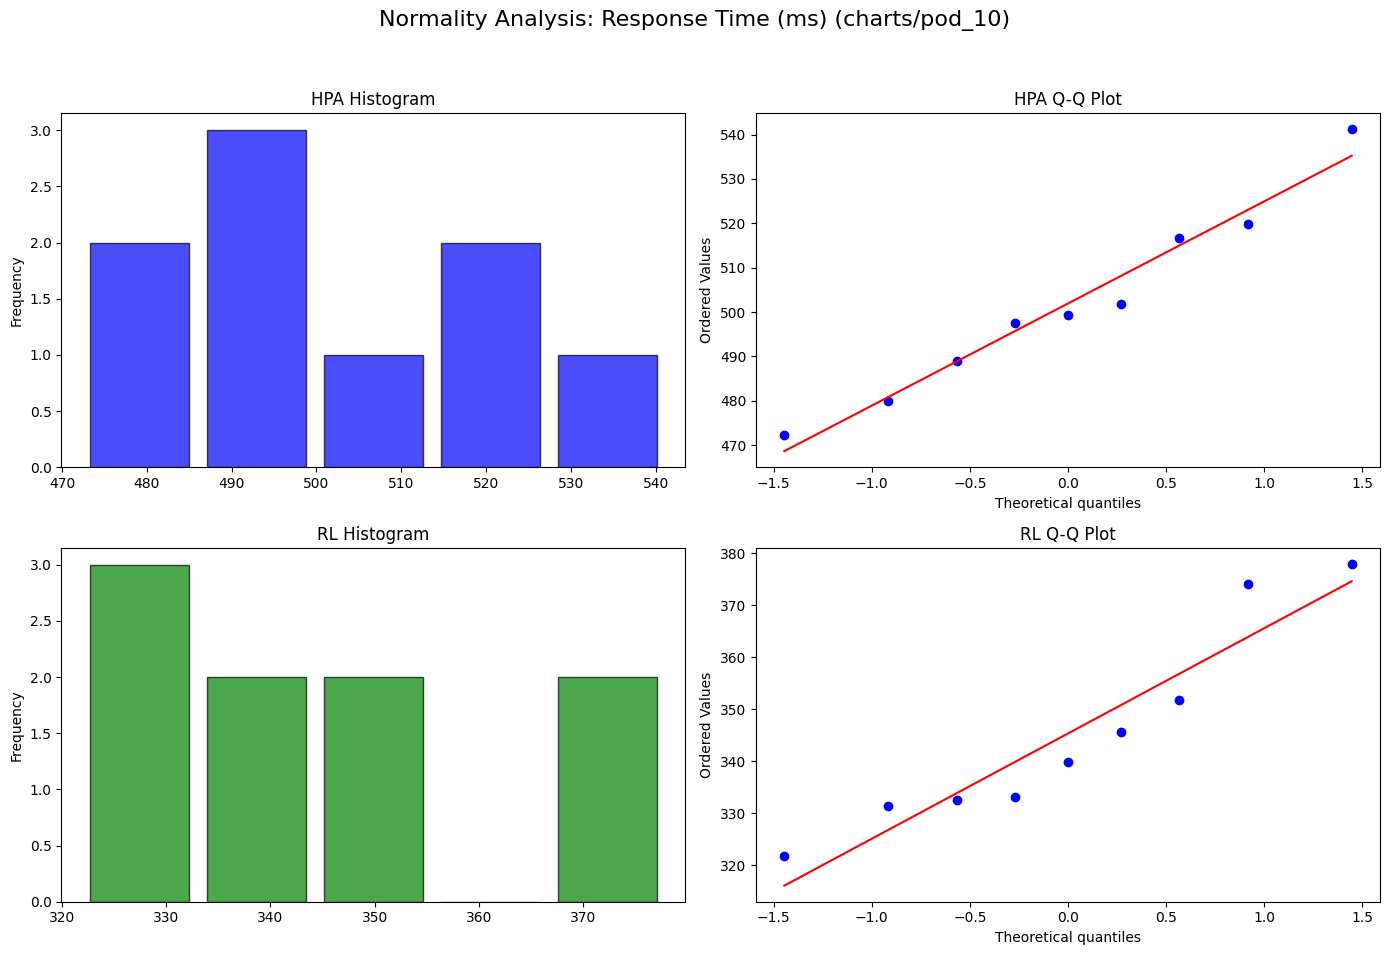


--- Processing Replica Count ---
Loaded ../pod_10/replica/1.csv: 722 rows
Loaded ../pod_10/replica/2.csv: 722 rows
Loaded ../pod_10/replica/3.csv: 722 rows
Loaded ../pod_10/replica/4.csv: 722 rows
Loaded ../pod_10/replica/5.csv: 722 rows
Loaded ../pod_10/replica/6.csv: 722 rows
Loaded ../pod_10/replica/7.csv: 722 rows
Loaded ../pod_10/replica/8.csv: 722 rows
Loaded ../pod_10/replica/9.csv: 712 rows
Saving plots to: charts/pod_10/replica/


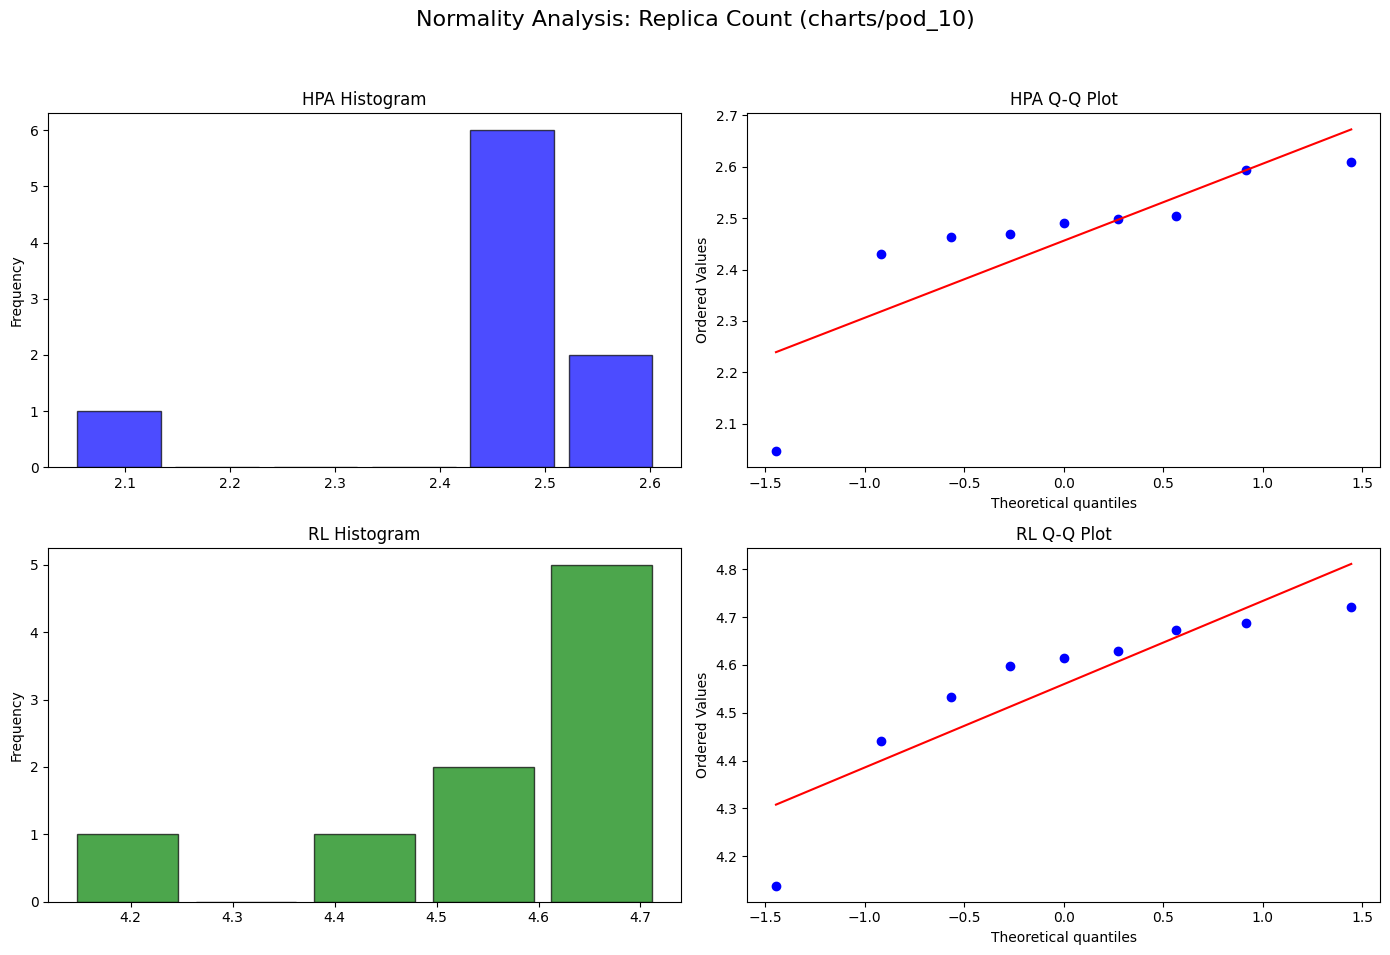


--- Processing CPU Usage ---
Loaded ../pod_10/cpu/1.csv: 722 rows
Loaded ../pod_10/cpu/2.csv: 722 rows
Loaded ../pod_10/cpu/3.csv: 722 rows
Loaded ../pod_10/cpu/4.csv: 722 rows
Loaded ../pod_10/cpu/5.csv: 722 rows
Loaded ../pod_10/cpu/6.csv: 722 rows
Loaded ../pod_10/cpu/7.csv: 722 rows
Loaded ../pod_10/cpu/8.csv: 722 rows
Loaded ../pod_10/cpu/9.csv: 718 rows
Saving plots to: charts/pod_10/cpu/


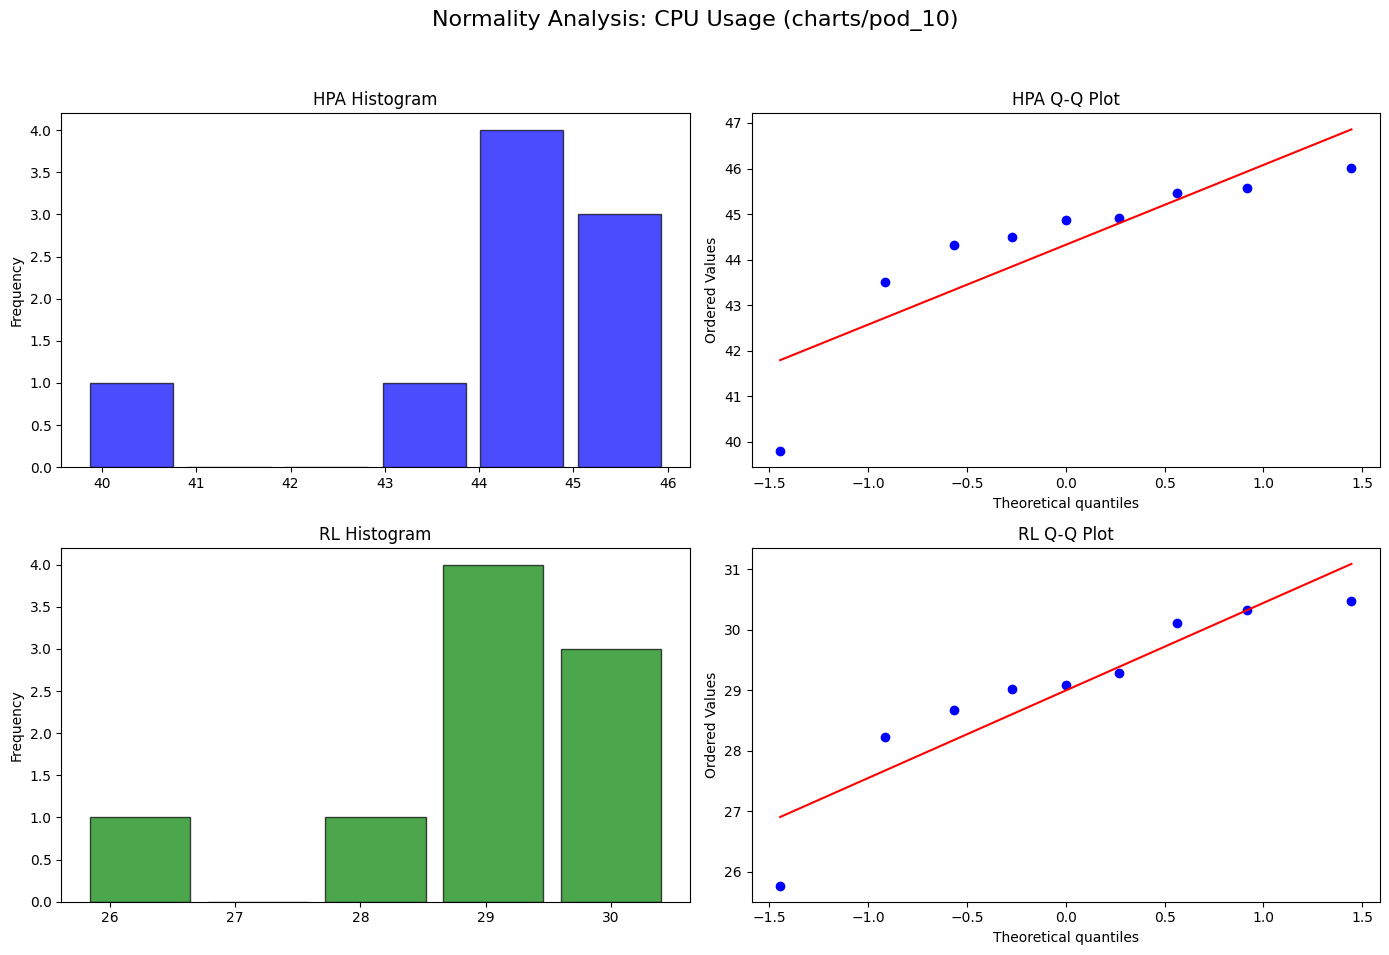


--- Processing Memory Usage ---
Loaded ../pod_10/memory/1.csv: 722 rows
Loaded ../pod_10/memory/2.csv: 722 rows
Loaded ../pod_10/memory/3.csv: 722 rows
Loaded ../pod_10/memory/4.csv: 722 rows
Loaded ../pod_10/memory/5.csv: 722 rows
Loaded ../pod_10/memory/6.csv: 722 rows
Loaded ../pod_10/memory/7.csv: 722 rows
Loaded ../pod_10/memory/8.csv: 722 rows
Loaded ../pod_10/memory/9.csv: 716 rows
Saving plots to: charts/pod_10/memory/


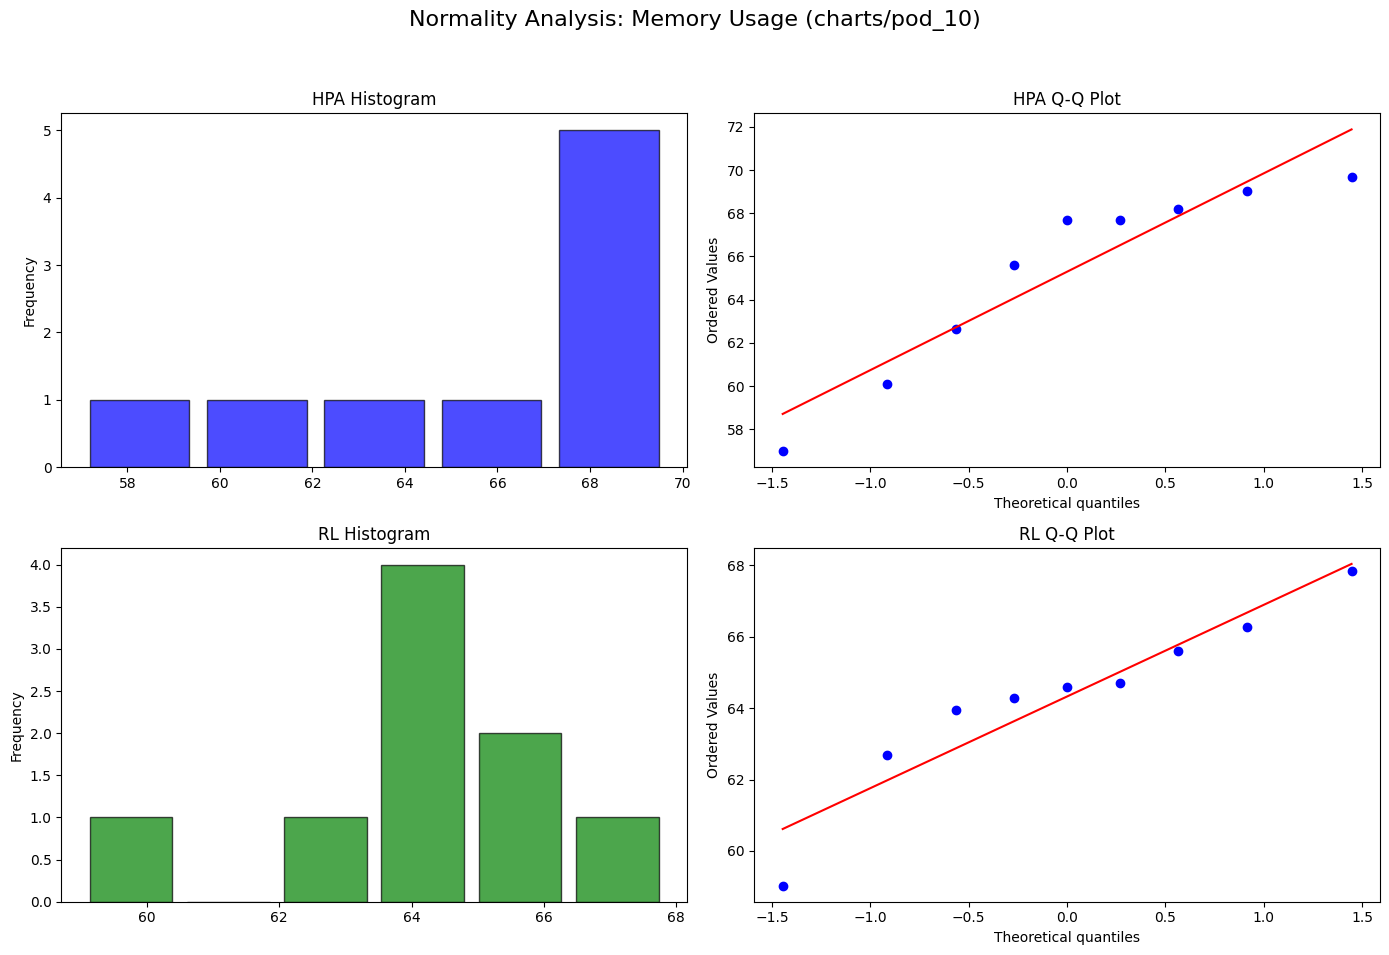


--- Processing Response Time (ms) ---
Loaded ../pod_20/response_time/1.csv: 722 rows
Loaded ../pod_20/response_time/2.csv: 722 rows
Loaded ../pod_20/response_time/3.csv: 722 rows
Loaded ../pod_20/response_time/4.csv: 722 rows
Loaded ../pod_20/response_time/5.csv: 722 rows
Loaded ../pod_20/response_time/6.csv: 722 rows
Loaded ../pod_20/response_time/7.csv: 722 rows
Loaded ../pod_20/response_time/8.csv: 722 rows
Loaded ../pod_20/response_time/9.csv: 722 rows
Loaded ../pod_20/response_time/10.csv: 722 rows
Saving plots to: charts/pod_20/response_time/


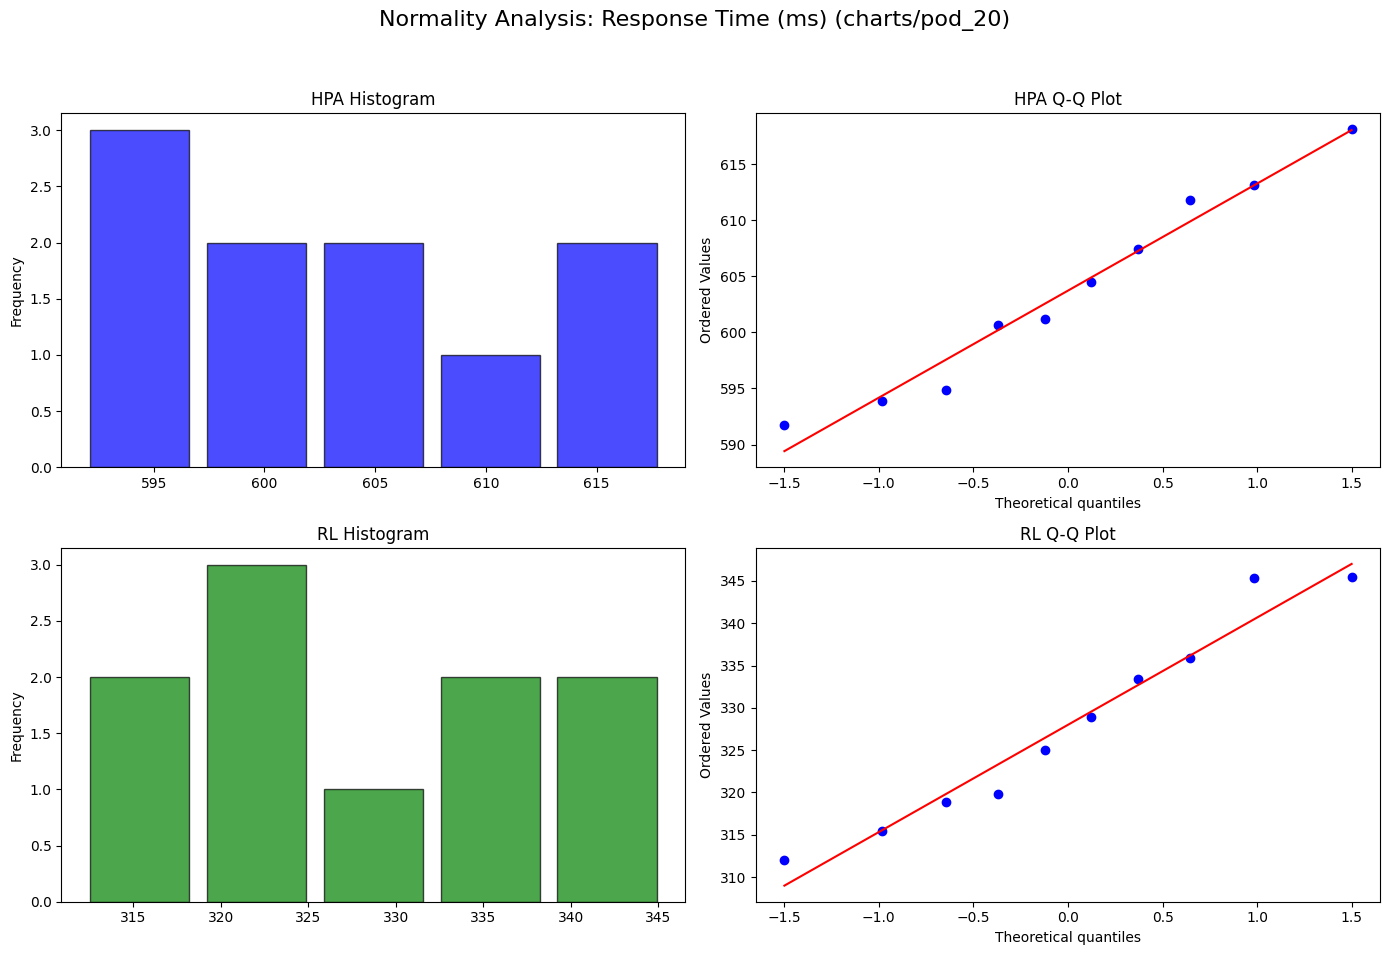


--- Processing Replica Count ---
Loaded ../pod_20/replica/1.csv: 722 rows
Loaded ../pod_20/replica/2.csv: 722 rows
Loaded ../pod_20/replica/3.csv: 722 rows
Loaded ../pod_20/replica/4.csv: 722 rows
Loaded ../pod_20/replica/5.csv: 722 rows
Loaded ../pod_20/replica/6.csv: 722 rows
Loaded ../pod_20/replica/7.csv: 722 rows
Loaded ../pod_20/replica/8.csv: 722 rows
Loaded ../pod_20/replica/9.csv: 722 rows
Loaded ../pod_20/replica/10.csv: 722 rows
Saving plots to: charts/pod_20/replica/


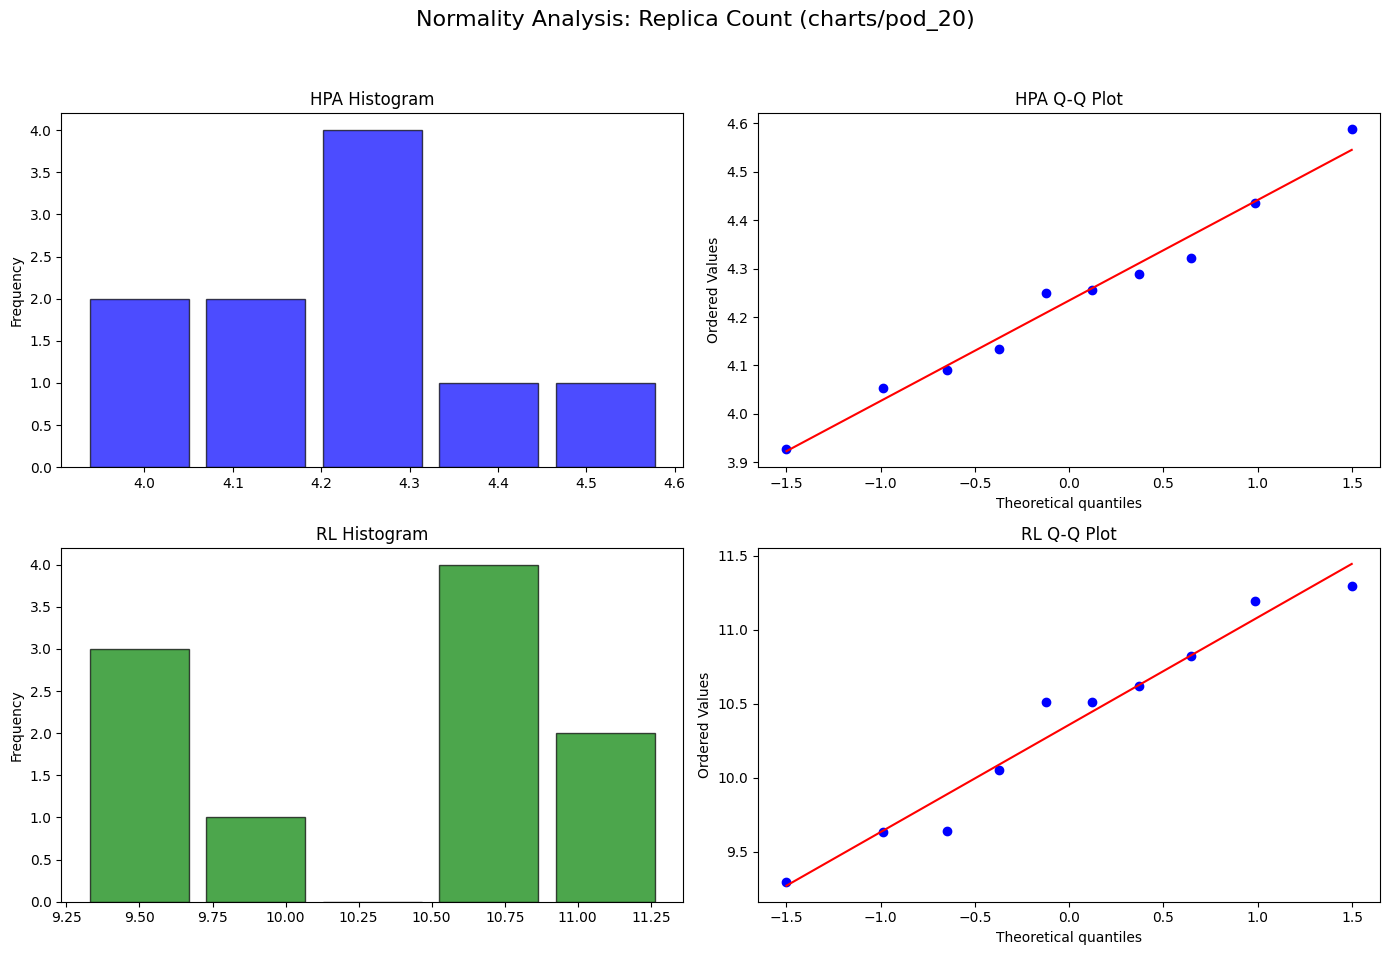


--- Processing CPU Usage ---
Loaded ../pod_20/cpu/1.csv: 722 rows
Loaded ../pod_20/cpu/2.csv: 722 rows
Loaded ../pod_20/cpu/3.csv: 722 rows
Loaded ../pod_20/cpu/4.csv: 722 rows
Loaded ../pod_20/cpu/5.csv: 722 rows
Loaded ../pod_20/cpu/6.csv: 722 rows
Loaded ../pod_20/cpu/7.csv: 722 rows
Loaded ../pod_20/cpu/8.csv: 722 rows
Loaded ../pod_20/cpu/9.csv: 722 rows
Loaded ../pod_20/cpu/10.csv: 722 rows
Saving plots to: charts/pod_20/cpu/


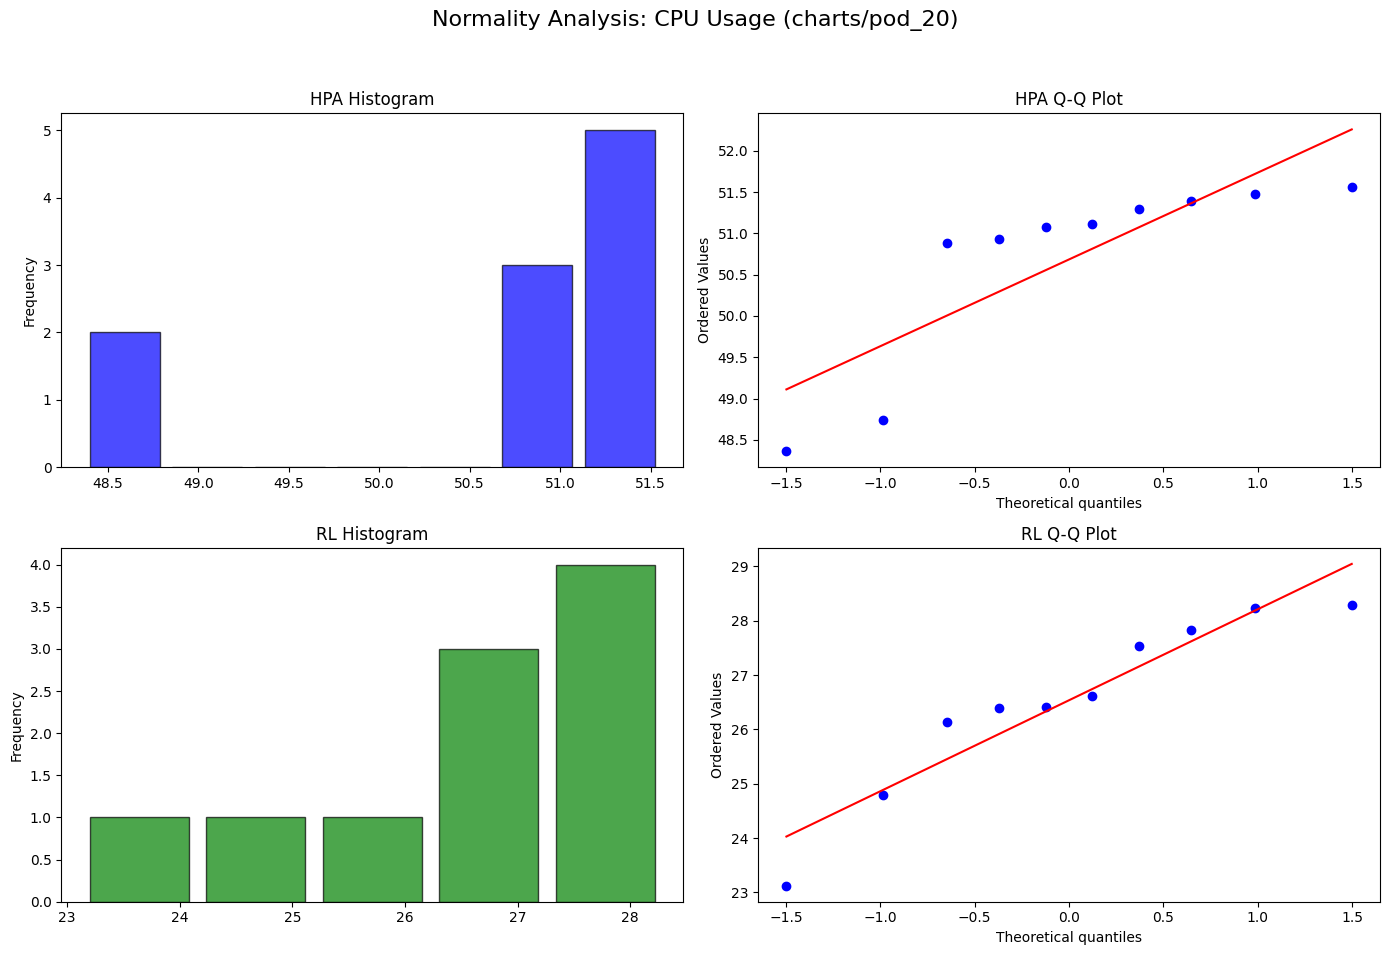


--- Processing Memory Usage ---
Loaded ../pod_20/memory/1.csv: 722 rows
Loaded ../pod_20/memory/2.csv: 722 rows
Loaded ../pod_20/memory/3.csv: 722 rows
Loaded ../pod_20/memory/4.csv: 722 rows
Loaded ../pod_20/memory/5.csv: 722 rows
Loaded ../pod_20/memory/6.csv: 722 rows
Loaded ../pod_20/memory/7.csv: 722 rows
Loaded ../pod_20/memory/8.csv: 722 rows
Loaded ../pod_20/memory/9.csv: 722 rows
Loaded ../pod_20/memory/10.csv: 722 rows
Saving plots to: charts/pod_20/memory/


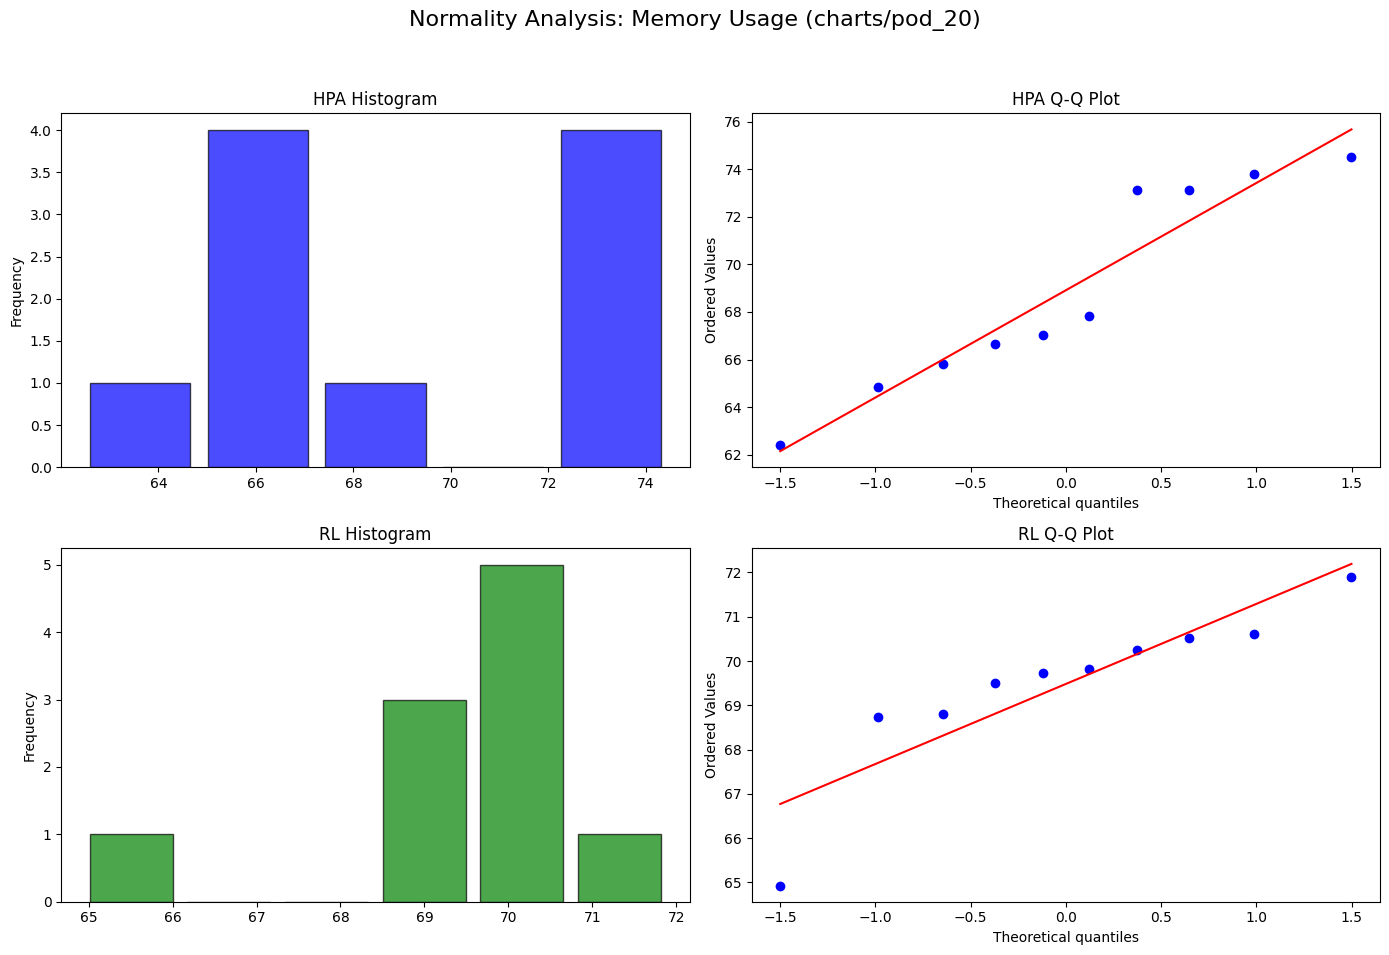


    Scenario              Metric   N    HPA Mean     RL Mean    Diff (%)  Normality P(HPA)  Normality P(RL)       P-Value  Significant           Test  Effect Size
0  ../pod_10  Response Time (ms)   9  501.925293  345.303492  -31.204206          0.899561         0.205507  1.183517e-07         True  Paired t-test     5.818596
1  ../pod_10       Replica Count   9    2.455821    4.559385   85.656208          0.002702         0.021107  3.906250e-03         True       Wilcoxon   -22.452933
2  ../pod_10           CPU Usage   9   44.325216   28.998235  -34.578468          0.008455         0.101226  3.906250e-03         True       Wilcoxon    11.525583
3  ../pod_10        Memory Usage   9   65.297059   64.328836   -1.482797          0.122537         0.418297  5.930706e-01        False  Paired t-test     0.185510
4  ../pod_20  Response Time (ms)  10  603.735786  328.001947  -45.671276          0.746590         0.512948  9.261275e-13         True  Paired t-test    17.715189
5  ../pod_20       Re

In [20]:

results = []
for folder, metric_dir, label, pod in METRICS:
    base_path = f"{folder}/{metric_dir}"
    if not os.path.exists(base_path): continue

    print(f"--- Processing {label} ---")
    hpa_vals, rl_vals = get_run_means(base_path)

    # Validate data length before plotting
    if len(hpa_vals) >= 3 and len(rl_vals) >= 3:
        # Pass folder and metric_dir to save in the correct path
        save_normality_plots(hpa_vals, rl_vals, f"charts/pod_{pod}", metric_dir, label, pod)

    stats_res = analyze_stats(hpa_vals, rl_vals)

    if stats_res:
        stats_res.update({"Scenario": folder, "Metric": label})
        results.append(stats_res)
    print("")

if results:
    columns = ["Scenario", "Metric", "N", "HPA Mean", "RL Mean", "Diff (%)",
               "Normality P(HPA)", "Normality P(RL)",
               "P-Value", "Significant", "Test", "Effect Size"]
    print(pd.DataFrame(results)[columns].to_string())
else:
    print("No valid data found for analysis.")

os.makedirs("tables", exist_ok=True)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Generate tables for each metric
tables = [
    ("Response Time (ms)", "tab:inferensial-waktu-respon", "Hasil Uji Inferensial Waktu Respons", "inferensial_waktu_respon.tex"),
    ("Replica Count", "tab:inferensial-jumlah-replika", "Hasil Uji Inferensial Jumlah Replika", "inferensial_jumlah_replika.tex"),
    ("CPU Usage", "tab:inferensial-penggunaan-cpu", "Hasil Uji Inferensial Penggunaan CPU", "inferensial_penggunaan_cpu.tex"),
    ("Memory Usage", "tab:inferensial-penggunaan-memori", "Hasil Uji Inferensial Penggunaan Memori", "inferensial_penggunaan_memori.tex"),
]

for metric_name, label, caption, filename in tables:
    latex_table = generate_latex_table(results_df, metric_name, label, caption)

    # Save to file
    with open(f"tables/{filename}", "w") as f:
        f.write(latex_table)

    print(f"Saved: tables/{filename}")
    print(latex_table)
    print("\n" + "="*80 + "\n")

## Cara Kerja Q-Q Plot (Quantile-Quantile Plot)

Q-Q plot adalah metode grafis untuk menguji apakah data mengikuti distribusi tertentu (dalam kasus ini: distribusi normal).

### **Konsep Dasar**
Q-Q plot membandingkan **quantile dari data sampel** dengan **quantile teoritis dari distribusi normal**. Jika data mengikuti distribusi normal, titik-titik akan berada di sepanjang garis diagonal.

### **Langkah Pembuatan Q-Q Plot**

#### **1. Urutkan Data**
Misalkan kita memiliki $n$ observasi: $x_1, x_2, ..., x_n$

Urutkan data menjadi: $x_{(1)} \leq x_{(2)} \leq ... \leq x_{(n)}$

#### **2. Hitung Sample Quantiles (Sumbu Y)**
Sample quantiles adalah nilai data yang sudah diurutkan: $x_{(i)}$

#### **3. Hitung Theoretical Quantiles (Sumbu X)**
Untuk setiap data ke-$i$, hitung posisi kuantil teoritis:

$$p_i = \frac{i - 0.5}{n}$$

Atau menggunakan formula alternatif:
$$p_i = \frac{i - 0.375}{n + 0.25}$$

Kemudian hitung theoretical quantile dari distribusi normal standar:
$$q_i = \Phi^{-1}(p_i)$$

Dimana:
- $\Phi^{-1}$ = inverse cumulative distribution function (CDF) dari distribusi normal standar
- $p_i$ = probabilitas kumulatif untuk data ke-$i$
- $q_i$ = theoretical quantile (nilai z-score)

#### **4. Plot Titik-Titik**
Buat scatter plot dengan:
- **Sumbu X:** Theoretical quantiles ($q_i$)
- **Sumbu Y:** Sample quantiles ($x_{(i)}$)

#### **5. Tambahkan Garis Referensi**
Garis diagonal merah dihitung dengan:
$$y = \mu + \sigma \cdot x$$

Dimana:
- $\mu$ = mean dari sampel data
- $\sigma$ = standar deviasi dari sampel data
- $x$ = theoretical quantile

### **Formula Lengkap untuk Scipy**

Dalam kode Python menggunakan `scipy.stats.probplot()`:

```python
stats.probplot(data, dist="norm", plot=plt)
```

Proses internal:
1. **Urutkan data:** $x_{(1)}, x_{(2)}, ..., x_{(n)}$
2. **Hitung plotting positions:**
   $$p_i = \frac{i - 0.375}{n + 0.25}$$
3. **Hitung theoretical quantiles:**
   $$q_i = \Phi^{-1}(p_i) = \text{norm.ppf}(p_i)$$
4. **Plot:** $(q_i, x_{(i)})$ untuk $i = 1, 2, ..., n$
5. **Fit line:** $y = a + b \cdot x$ menggunakan least squares

### **Interpretasi Visual**

| Pattern | Arti |
|---------|------|
| **Titik di sepanjang garis** | Data normal ✓ |
| **Kurva 'S'** | Data memiliki tails yang lebih ringan/berat dari normal |
| **Kurva cekung** | Right-skewed (ekor ke kanan) |
| **Kurva cembung** | Left-skewed (ekor ke kiri) |
| **Titik terpisah di ujung** | Outliers |

### **Contoh Perhitungan Manual**

Misalkan kita punya data: [2.1, 2.5, 2.7, 4.5, 4.7]

**Step 1:** Data sudah urut ✓

**Step 2:** Sample quantiles = [2.1, 2.5, 2.7, 4.5, 4.7]

**Step 3:** Hitung theoretical quantiles untuk $n=5$:
- $p_1 = \frac{1-0.375}{5+0.25} = 0.119$ → $q_1 = \Phi^{-1}(0.119) = -1.18$
- $p_2 = \frac{2-0.375}{5+0.25} = 0.310$ → $q_2 = \Phi^{-1}(0.310) = -0.50$
- $p_3 = \frac{3-0.375}{5+0.25} = 0.500$ → $q_3 = \Phi^{-1}(0.500) = 0.00$
- $p_4 = \frac{4-0.375}{5+0.25} = 0.690$ → $q_4 = \Phi^{-1}(0.690) = 0.50$
- $p_5 = \frac{5-0.375}{5+0.25} = 0.881$ → $q_5 = \Phi^{-1}(0.881) = 1.18$

**Step 4:** Plot pairs: $(-1.18, 2.1)$, $(-0.50, 2.5)$, $(0.00, 2.7)$, $(0.50, 4.5)$, $(1.18, 4.7)$

**Step 5:** Fit line melalui titik-titik ini

### **Hubungan dengan Shapiro-Wilk Test**

Q-Q plot adalah **visualisasi**, sedangkan Shapiro-Wilk adalah **uji statistik**:
- **Q-Q plot:** Memberikan insight visual tentang jenis deviasi dari normalitas
- **Shapiro-Wilk:** Memberikan nilai *p* untuk keputusan statistik (reject/fail to reject H₀)

**Best Practice:** Gunakan keduanya bersama-sama untuk analisis lengkap!

Data terurut: [2.1 2.3 2.5 2.7 3.1 3.8 4.2 4.5 4.7]

Plotting positions (p_i): [0.06756757 0.17567568 0.28378378 0.39189189 0.5        0.60810811
 0.71621622 0.82432432 0.93243243]
Theoretical quantiles (z-scores): [-1.49415491 -0.93197131 -0.57163753 -0.27439149  0.          0.27439149
  0.57163753  0.93197131  1.49415491]


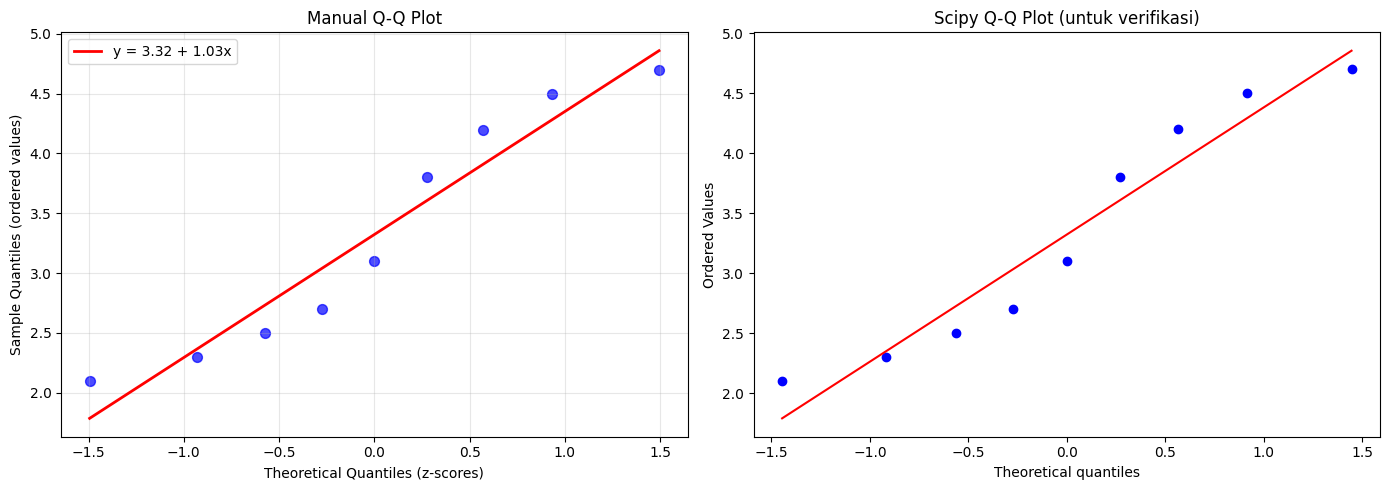


Garis fit: y = 3.322 + 1.029x
Dimana: intercept ≈ mean = 3.322
        slope ≈ std = 0.996


In [21]:
# Contoh Implementasi Manual Q-Q Plot
# Untuk memahami cara kerjanya secara detail

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Data contoh
data = np.array([2.1, 2.5, 2.7, 4.5, 4.7, 2.3, 3.1, 3.8, 4.2])
n = len(data)

# Step 1: Urutkan data
sorted_data = np.sort(data)
print("Data terurut:", sorted_data)

# Step 2: Hitung theoretical quantiles
# Menggunakan formula: p_i = (i - 0.375) / (n + 0.25)
i = np.arange(1, n + 1)
p_i = (i - 0.375) / (n + 0.25)
theoretical_quantiles = stats.norm.ppf(p_i)  # Inverse CDF dari normal standar

print("\nPlotting positions (p_i):", p_i)
print("Theoretical quantiles (z-scores):", theoretical_quantiles)

# Step 3: Plot manual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Manual Q-Q Plot
axes[0].scatter(theoretical_quantiles, sorted_data, color='blue', s=50, alpha=0.7)

# Fit line: y = a + b*x
slope, intercept = np.polyfit(theoretical_quantiles, sorted_data, 1)
line_x = np.array([theoretical_quantiles.min(), theoretical_quantiles.max()])
line_y = slope * line_x + intercept
axes[0].plot(line_x, line_y, 'r-', linewidth=2, label=f'y = {intercept:.2f} + {slope:.2f}x')

axes[0].set_xlabel('Theoretical Quantiles (z-scores)')
axes[0].set_ylabel('Sample Quantiles (ordered values)')
axes[0].set_title('Manual Q-Q Plot')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Scipy Q-Q Plot untuk perbandingan
stats.probplot(data, dist="norm", plot=axes[1])
axes[1].set_title('Scipy Q-Q Plot (untuk verifikasi)')

plt.tight_layout()
plt.show()

print(f"\nGaris fit: y = {intercept:.3f} + {slope:.3f}x")
print(f"Dimana: intercept ≈ mean = {np.mean(data):.3f}")
print(f"        slope ≈ std = {np.std(data, ddof=1):.3f}")

### Penjelasan Output Contoh di Atas:

**1. Data Terurut:**
- Data asli diurutkan dari terkecil ke terbesar
- Ini menjadi **sample quantiles** (sumbu Y)

**2. Plotting Positions (p_i):**
- Probabilitas kumulatif untuk setiap titik data
- Dihitung dengan: $p_i = \frac{i - 0.375}{n + 0.25}$
- Contoh: untuk data pertama ($i=1$, $n=9$): $p_1 = \frac{1-0.375}{9+0.25} = 0.068$

**3. Theoretical Quantiles (z-scores):**
- Inverse CDF dari distribusi normal standar: $\Phi^{-1}(p_i)$
- Ini adalah **sumbu X** pada Q-Q plot
- Contoh: $\Phi^{-1}(0.068) = -1.494$ (nilai z-score)
- Nilai tengah ($p=0.5$) menghasilkan $z=0$ (median distribusi normal)

**4. Garis Fit:**
- Persamaan: $y = 3.322 + 1.029x$
- **Intercept (3.322)** ≈ mean dari data
- **Slope (1.029)** ≈ standar deviasi dari data
- Jika data normal sempurna: titik-titik akan berada **tepat** di garis ini

**5. Interpretasi:**
- Titik-titik di grafik manual mendekati garis merah → data mendekati normal
- Kedua grafik (manual vs scipy) identik → verifikasi bahwa implementasi benar
- Deviasi kecil dari garis adalah normal untuk sampel kecil ($n=9$)

**Kesimpulan:** Q-Q plot mengubah data empiris menjadi sistem koordinat yang memungkinkan kita membandingkan dengan distribusi teoritis secara visual!

### How to Read the Normality Plots
**1. Q-Q Plot (Right Side) - The Main Indicator**
*   **Normal:** The blue dots follow the red diagonal line.
*   **Not Normal:** The dots curve away (like a banana or 'S' shape) or are scattered far from the line.

**2. Histogram (Left Side) - The Shape**
*   **Normal:** Looks like a "Bell Curve" (tall in middle, short on ends).
*   **Note:** With small data samples (N < 20), histograms often look "blocky" or messy. **Trust the Q-Q Plot more.**

## LaTeX Tables Generated

The inferential test results have been converted to LaTeX table format and saved in the `tables/` directory:

1. **[tables/response_time.tex](tables/response_time.tex)** - Hasil Uji Inferensial Waktu Respons
2. **[tables/memory.tex](tables/memory.tex)** - Hasil Uji Inferensial Penggunaan Memori  
3. **[tables/cpu.tex](tables/cpu.tex)** - Hasil Uji Inferensial Penggunaan CPU
4. **[tables/replica.tex](tables/replica.tex)** - Hasil Uji Inferensial Jumlah Replika

Each table includes:
- Sample size (N)
- Mean values for HPA and RL
- Percentage difference
- Normality test p-values
- Statistical test used (Paired t-test or Wilcoxon)
- P-value with scientific notation where appropriate
- Significance indicator
- Effect size (Cohen's d or r depending on test)